In [104]:
import pydot
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
import math
from statistics import mean 
from collections import Counter
import numpy as np
from numpy import linalg as LA
import copy
from sklearn.manifold import MDS, TSNE

## Data to nodes and edges

In [3]:
def parse_dot_file(file_path):
    '''Turn dot file to nodes and edges'''
    graph = pydot.graph_from_dot_file(file_path)[0]  # Get the first graph from the list
    nodes = []
    edges = []
    for node in graph.get_nodes(): #extracts nodes
        nodes.append(node.get_name())
    for edge in graph.get_edges(): #extracts edges
        source = edge.get_source()
        target = edge.get_destination()
        attributes = edge.get_attributes()
        edges.append((source, target, attributes))
        
    num_nodes = len(nodes)
    '''Turn the nodes and edges to adjencecy matrix'''
    adj_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for i, edge in enumerate(edges):
        source = edge[0]
        target = edge[1]
        weight = edge[2]
        try:
            adj_matrix[nodes.index(source)][nodes.index(target)] = weight['weight']
        except KeyError:
            adj_matrix[nodes.index(source)][nodes.index(target)] = 1
    return nodes, edges, adj_matrix

file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/LesMiserables.dot"
#LesMiserables, LeagueNetwork, polblogs, JazzNetwork, noname
nodes, edges, adj_matrix = parse_dot_file(file_path)

## Step 1: Basic MatplotLib Graph Drawing

In [4]:
# Function to arrange nodes in a square-like layout
def arrange_in_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))
    spacing = 50
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y)
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row
    return node_positions

def arrange_in_radial(nodes):
    num_nodes = len(nodes)
    radius = 200
    angle_step = 360 / num_nodes
    node_positions = {}
    for i, node in enumerate(nodes):
        angle = math.radians(i * angle_step)
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        node_positions[node] = (x, y)
    return node_positions

def arrange_in_semi_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))  # Calculate the side length of the square
    spacing = 60  # Spacing between nodes
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y + random.randint(-15, 15))
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row

    return node_positions

In [5]:
def draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size=300, directed=False): 
    fig, ax = plt.subplots()
               
    # Draw nodes and labels
    for node, pos in node_positions.items():
        if 'd' in node: #if it is a dummy
            ax.scatter(pos[0], pos[1], s=node_size/2, color=node_colors[node], edgecolors='black', zorder=5, marker="s")  # Draw node
        elif not '|' in node:
            ax.scatter(pos[0], pos[1], s=node_size, color=node_colors[node], edgecolors='black', zorder=5)  # Draw node
        ax.text(pos[0], pos[1], node[0:4], ha='center', va='center', fontsize=8, zorder=10)  # Add label
        
    # Draw edges
    for edge in edges:
        source, target, _ = edge
        start = node_positions[source]
        end = node_positions[target]
        if 'd' in source: #if it is a dummy
            original_source = source
            while 'd' in original_source:
                original_source = [other_source for other_source, other_target, weight in edges if other_target == source][0]
                source = original_source
            ax.plot([start[0], end[0]], [start[1], end[1]], color=node_colors[original_source], zorder=0)  # Draw edge
#         elif directed: #TODO YVETTE
#             ax.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1], length_includes_head=True, head_width = np.sum(np.abs(ax.get_xlim()))/40, color=node_colors[source], zorder=0) # Draw arrow
        else:
            ax.plot([start[0], end[0]], [start[1], end[1]], color=node_colors[source], zorder=0)  # Draw edge
            
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)    
    plt.show()

## Step 2: Undirected Tree based algorithm + DFS&BFS

### Tree structure

In [6]:
def arrange_in_tree(nodes, edges, root=None):
    num_nodes = len(nodes)
    node_positions = {}
    if root == None:
        root = nodes[0]
        
    node_positions[root] = (0, 0) 
    layer_space = 1
    node_space = 1
    padding = 10

    queue = [root]
    past_nodes = []
    '''Tree creation'''
    while queue != []:
        current_node = queue[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in past_nodes]
        if children_nodes != []: 
            segment_length = node_space / len(children_nodes)
            parent_coords = node_positions[current_node]
            for i, children_node in enumerate(children_nodes):
                if children_node not in node_positions:
                    new_x = -node_space/2+segment_length*(0.5+i)
                    new_y = parent_coords[1]-layer_space
                    node_positions[children_node] = (new_x, new_y)
            queue = children_nodes + queue
        queue.remove(current_node)
        past_nodes.append(current_node)
        
        
    '''Improve node positions in tree '''
    #this part will calculate what the max and min x&y-coordinate for the graph to determine the most rightest & leftest etc. place
    layer_min_max = {} 
    for node, node_pos in node_positions.items():
        layer = node_pos[1] #y-as
        x_coord = node_pos[0] #x-as
        if layer not in layer_min_max:
            layer_min_max[layer] = [x_coord, x_coord]
        else:
            if x_coord < layer_min_max[layer][0]:
                layer_min_max[layer][0] = x_coord
            if x_coord > layer_min_max[layer][1]:
                layer_min_max[layer][1] = x_coord

    # Move nodes which are already in the same layer and divide them equally through the layer
    for layer, (min_x, max_x) in layer_min_max.items():
        layer_nodes = [(node, pos) for node, pos in node_positions.items() if pos[1] == layer]
#         if len(layer_nodes) > 5:
        if len(layer_nodes) > 2: #TODO fix visual
            interval = (max_x - min_x) / (len(layer_nodes) - 1)
            for i, (node, pos) in enumerate(layer_nodes):
                new_x = min_x + i * interval
                node_positions[node] = (new_x, pos[1])
#             print(node_positions)
        elif layer_nodes[0][1][1] < 0: #check if not first layer and not a lot of nodes, connected them with their parents by giving the parent's node x-as
            for i, layer_node in enumerate(layer_nodes):
                parent_node = [parent_node[0] for parent_node in edges if parent_node[1] == layer_node[0]]
                middle_parent_node_coords = mean([parent_node_coords[1][0] for parent_node_coords in previous_layer_nodes if parent_node_coords[0] in parent_node])
                node_positions[layer_node[0]] = (middle_parent_node_coords, layer_node[1][1])
        layer_nodes = [(node, pos) for node, pos in node_positions.items() if pos[1] == layer]        
        previous_layer_nodes = layer_nodes.copy()
    return node_positions

### Search Algorithms

In [27]:
def DFS(nodes, edges, search_root=None, node_size=200):
    '''DFS'''
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    stack = [search_root]
    visited = []
    DFS_edges = []
    while stack != []:
        current_node = stack[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in visited]        
        if children_nodes != []:
            for children_node in children_nodes:
                if children_node in stack:
                    stack.remove(children_node)
                stack[stack.index(current_node):stack.index(current_node)] = [children_node]
            for edge in edges:
                if (edge[0] == current_node and edge[1] == children_nodes[0] 
                     and edge[1] not in [elem[1] for elem in DFS_edges]): #same source and if target is first edge
                    DFS_edges.append(edge)
                elif (edge[1] == current_node and edge[0] == children_nodes[0]
                      and edge[0] not in [elem[0] for elem in DFS_edges]): #viceversa cuz undirected
                    DFS_edges.append((edge[1], edge[0], edge[2]))
        elif len(visited) != len(nodes):
            stack.insert(0,[elem[0] for elem in DFS_edges if elem[1] == current_node][0])
        if current_node not in visited:
            visited.append(current_node)
        stack.remove(current_node)
    return DFS_edges, visited

def BFS(nodes, edges, search_root=None, node_size=200):
    '''BFS'''
    BFS_edges = []
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    queue = [search_root]
    layers = [[search_root]]
    visited = []
    distance_matrix = np.inf * np.ones((num_nodes, num_nodes))
    while queue != []:
        current_node = queue[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        parent_nodes = [value for edge in connected_edges for value in edge if value != current_node and value not in visited and current_node != edge[0]]
        children_nodes = [value for edge in connected_edges for value in edge if value != current_node and value not in visited and current_node != edge[1]]
        connected_nodes = parent_nodes + children_nodes
#         print("layers", layers, "parent", parent_nodes, "child", children_nodes, "conn", connected_nodes)
        
        for node in connected_nodes:
            if node not in visited:
                node_index = nodes.index(node)
                distance_matrix[nodes.index(search_root), node_index] = 1
        
        if connected_nodes != []:
            for connected_node in connected_nodes:
                if connected_node not in queue:
                    queue.append(connected_node)
                for edge in edges:
                    if (edge[0] == current_node and edge[1] == connected_node
                       and edge[1] not in [elem[1] for elem in BFS_edges]): #same source and if target is first edge
                        BFS_edges.append(edge)
                    elif (edge[1] == current_node and edge[0] == connected_node
                          and edge[0] not in [elem[0] for elem in BFS_edges]): #viceversa cuz undirected
                        BFS_edges.append((edge[1], edge[0], edge[2]))
        if current_node not in visited:
            visited.append(current_node)
            for i, layer in enumerate(layers):
                if current_node in layer:
                    for connected_node in connected_nodes:
                        if connected_node in parent_nodes:
                            layers[i-1].append(connected_node) #parent
                        else:
                            try:
                                layers[i+1].append(connected_node) #child
                            except IndexError:
                                layers.append([connected_node])
        queue.remove(current_node)
        if queue == [] and len(visited) < len(nodes): #if multiple trees
            not_visited = [x for x in nodes if x not in visited]
            layers.append(['|' , not_visited[0]])
            queue = [not_visited[0]] 
    return BFS_edges, visited, layers, distance_matrix


    
def search_through_tree(nodes, edges, node_positions, node_colors, search_root=None, node_size=200):
#     print("DFS")
#     DFS_edges, DFS_visited = DFS(nodes, edges, search_root) 
#     print('DFS Visit order', DFS_visited)
#     DFS_node_positions = arrange_in_tree(nodes, DFS_edges, search_root)
#     draw_node_link_diagram(DFS_visited, DFS_edges, DFS_node_positions, node_colors, node_size)
#     print('DFS removed edges: ', [x[:2] for x in edges if x not in DFS_edges])
    
    print("BFS")
    BFS_edges, BFS_visited, layers, _ = BFS(nodes, edges, search_root) 
#     print('BFS Visit order', BFS_visited) #~ ADD LATER
    BFS_node_positions = arrange_in_tree(nodes, BFS_edges, search_root)
    draw_node_link_diagram(BFS_visited, BFS_edges, BFS_node_positions, node_colors, node_size)
#     print('BFS removed edges: ', [x[:2] for x in edges if x not in BFS_edges]) #~ ADD LATER


## Step 3: Force directed layout

In [88]:
def arrange_in_force(nodes, edges, k, iterations):
    # Call Fruchterman-Reingold function and return node positions
    node_positions = fruchterman_reingold(nodes, edges, iterations, k)
    
#     initial_node_positions = initialize_node_positions(nodes)
#     enforced_node_positions = enforce_spacing(initial_node_positions)
#     final_node_positions = apply_forces(nodes, edges, enforced_node_positions)
    return node_positions

In [89]:
def fruchterman_reingold(nodes, edges, iterations, k, temperature=1.0, cooling_factor=0.95):
    # Fruchterman-Reingold force-directed layout algorithm
    # Initialize node positions randomly
    node_positions = {node: (random.random(), random.random()) for node in nodes}
    
    # function to calculate repulsive force between two nodes
    def repulsive_force(pos1, pos2, k):
        dx = pos2[0] - pos1[0]
        dy = pos2[1] - pos1[1]
        distance_squared = max(dx**2 + dy**2, 0.01)  # Avoid division by zero
        return (-dx / distance_squared) * k, (-dy / distance_squared) * k
    
    # function to calculate attractive force between two nodes
    def attractive_force(pos1, pos2, k):
        dx = pos2[0] - pos1[0]
        dy = pos2[1] - pos1[1]
        distance = max(math.sqrt(dx**2 + dy**2), 0.01)  # Avoid division by zero
        return (dx / distance) * k, (dy / distance) * k


    # Perform iterations of the Fruchterman-Reingold algorithm
    for _ in range(iterations):
        # Calculate repulsive forces between all pairs of nodes
        for node1, pos1 in node_positions.items():
            node_positions[node1] = (0, 0)
            for node2, pos2 in node_positions.items():
                if node1 != node2:
                    force_x, force_y = repulsive_force(pos1, pos2, k)
                    node_positions[node1] = (node_positions[node1][0] + force_x, node_positions[node1][1] + force_y)
        # Calculate attractive forces between connected nodes
        for edge in edges:
            source, target, _ = edge
            force_x, force_y = attractive_force(node_positions[source], node_positions[target], k)
            node_positions[source] = (node_positions[source][0] + force_x, node_positions[source][1] + force_y)
            node_positions[target] = (node_positions[target][0] - force_x, node_positions[target][1] - force_y)
        # Update node positions based on forces and temperature
        for node, pos in node_positions.items():
            dx = min(abs(pos[0]), temperature) * (1 if pos[0] >= 0 else -1)
            dy = min(abs(pos[1]), temperature) * (1 if pos[1] >= 0 else -1)
            node_positions[node] = (pos[0] - dx, pos[1] - dy)
        # Cool down temperature
        temperature *= cooling_factor
    return node_positions

## Step 4: Layered Layout 

In [9]:
def get_parents(edges, node, parents=None, parent_number=None):
    if parents is None:
        parents = {}
    if parent_number is None: #parent_number is the number of layer it is above the current node
        parent_number = 0
        
    for edge in edges:
        if edge[1] == node:
            parent = edge[0]
            if parent not in parents:
                parent_number += 1
                parents[parent] = parent_number
                get_parents(edges, parent, parents, parent_number)
    
    return parents

In [10]:
def get_childs(edges, node, childs=None, child_number=None):
    if childs is None:
        childs = {}
    if child_number is None:
        child_number = 0
        
    for edge in edges:
        if edge[0] == node:
            child = edge[1]
            if child not in childs:
                child_number -= 1
                childs[child] = child_number
                get_childs(edges, node, childs, child_number)
    
    return childs

In [11]:
def sugiyama_framework(nodes, edges, node_colors, root=None, node_size=200):
    def guarantee_heuristic(nodes, edges):
        '''Find the edges to be reversed to avoid cyclic graph'''
        print("Heuristic with guarantees")
        #Part 1: Sinks (only receiving edges) 
        original_nodes = set(nodes) #turn the nodes to set, to use the handy set functions
        while True:
            sinks_edges = {node: [(source, target, weight) for source, target, weight in edges if target == node] for node in set([edge[1] for edge in edges]) - set([edge[0] for edge in edges])}
            removable_edges = [element for innerList in sinks_edges.values() for element in innerList]
            edges = [edge for edge in edges if edge not in removable_edges]             # Remove edges corresponding to the sink nodes
            current_nodes = set([node for edge in edges for node in edge[:2]]) #new nodes
            if current_nodes == original_nodes: # if the current set of nodes is the same as the original set, exit loop
                break
            else: # otherwise, update the set of nodes for the next iteration
                original_nodes = current_nodes
                nodes = list(original_nodes) #turn it back to the original list type
        print("Removed sinks:")
        _, _, node_positions = layer_assignment(nodes, edges, root=None)
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)       
        
        
        #Part 2: Sources (only outcoming edges)
        original_nodes = set(nodes) #turn the nodes to set, to use the handy set functions
        while True:
            sources_edges = {node: [(source, target, weight) for source, target, weight in edges if source == node] for node in set([edge[0] for edge in edges]) - set([edge[1] for edge in edges])}
            removable_edges = [element for innerList in sources_edges.values() for element in innerList]
            edges = [edge for edge in edges if edge not in removable_edges]
            current_nodes = set([node for edge in edges for node in edge[:2]])
            if current_nodes == original_nodes:
                break
            else:
                original_nodes = current_nodes
                nodes = list(original_nodes)
        print("Removed sources:")
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)

        #Part 3: Inversing the edges
        # Create a Counter to count the occurrences of each node in the edge structure (+1 if it a source -1 if it a target)
        node_counter = Counter()
        for source, target, weight in edges:
            node_counter[source] += 1 # N ->
            node_counter[target] -= 1 # N <-
        nodes = sorted(node_counter, key=node_counter.get, reverse=True) #get counter in reversed aka descending order
        cycle_edges = []
        for node in nodes:
            temp_edges = []
            for edge in edges:
                if edge[0] != node or edge in cycle_edges:
                    temp_edges.append(edge)
                if edge[1] == node:
                    cycle_edges.append(edge)
            edges = temp_edges
            
        print("Found cycle edges")
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
        return edges
            
    def layer_assignment(nodes, edges, root=None):
        #add to layers from root
        if root == None:
            root = nodes[0]
        BFS_edges, BFS_visited, layers = BFS(nodes, edges, root) 
        print('BFS Visit order', BFS_visited)
        print('BFS removed edges: ', [x[:2] for x in edges if x not in BFS_edges])
        node_positions = {}
        layer_counter = 0
        node_space = 0
        placed_nodes_in_layers = copy.deepcopy(layers)
        for index, layer in enumerate(layers):
            if "|" in layer:
                layer_counter = 0
            for node in layer: #loops through the layers
                if node not in node_positions:  #if the first time encountering a node place it
                    node_positions[node] = (node_space, layer_counter)
                    node_space += 1                  
                else: #if not, then also move every parent from that node to the current position of the node
                    node_parents = get_parents(edges, node)
                    for node_parent, parent_layer in node_parents.items():
                        if node_parent in node_positions:
                            node_positions[node_parent] = (node_positions[node_parent][0], node_positions[node][1] + parent_layer)
                        else:
                            node_positions[node_parent] = (node_space, node_positions[node][1] + parent_layer)
            layer_counter -= 1
        #Adjusting the nodes which have parents/childs that have only dummies in between them
        for node, (x, y) in node_positions.items():
            node_childs = [key for key, value in get_childs(edges, node).items() if value <= 2] 
            node_parents = [key for key, value in get_parents(edges, node).items() if value <= 2] 
            if list(node_childs) != []:
                if y-1 != max(node_positions[node_child][1] for node_child in node_childs): 
                    #if the max y-as of a child isn't directly under the current node
                    node_positions[node] = (x, y-1) #move it down
            elif list(node_parents) != []:
                if y+1 != min(node_positions[node_parent][1] for node_parent in node_parents): 
                    #if the min y-as of a parent isn't directly above the current node
                    node_positions[node] = (x, y+1) #move it up
        
#         #Add dummies
#         layer_crossing_edges = [edge for edge in edges if abs(node_positions[edge[0]][1] - node_positions[edge[1]][1]) >= 2]
#         dummy_number = 0
#         while layer_crossing_edges != []:
#             for index, edge in enumerate(layer_crossing_edges):
#                 dummy_number += 1
#                 dummy_name = 'd'+str(dummy_number)
#                 nodes.append(dummy_name) #add dummy to node list
#                 node_colors[dummy_name] = "#808080" #add its color 
#                 node_positions[dummy_name] = (((node_positions[edge[0]][0] + node_positions[edge[1]][0])/2), round((node_positions[edge[0]][1] + node_positions[edge[1]][1])/2))
#                 edges.append((edge[0], dummy_name, edge[2]))
#                 edges.append((dummy_name, edge[1], edge[2]))
#                 edges.remove(edge)
#             layer_crossing_edges = [edge for edge in edges if abs(node_positions[edge[0]][1] - node_positions[edge[1]][1]) >= 2]

        return nodes, edges, node_positions
    
    def crossing_minimization(nodes, edges, node_positions, method="Barycenter"):
        layers = sorted(set(y for _, (_, y) in node_positions.items()), reverse=True)
        
        def implement_new_x (node, node_positions, barycenter_x, neighbors):
            node_positions[node] = (barycenter_x, node_positions[node][1])
            return node_positions
        
        def calculate_barycenter(node, parents, node_positions, neighbors):
            parents_x_sum = sum(node_positions[parent][0] for parent in parents)
            if parents_x_sum == 0:
                barycenter_x = node_positions[node][0]
            else:
                barycenter_x = parents_x_sum / len(parents)
#             print(node, neighbors, barycenter_x)
            node_positions = implement_new_x (node, node_positions, barycenter_x, neighbors)
            return node_positions
        
        #calculate first barycenter
        for layer in layers[:-1]:
            nodes_in_curr_layer = [node for node, (x, y) in node_positions.items() if y == layer]
            nodes_in_next_layer = [node for node, (x, y) in node_positions.items() if y == layer-1]
            has_parents = {node: [] for node in nodes_in_next_layer}
            for node in nodes_in_next_layer:
                for source, target, _ in edges:
                    if target == node:
                        has_parents[node].append(source)
#                 print(layer-1, "parents", has_parents)    
                node_positions = calculate_barycenter(node, has_parents[node], node_positions, nodes_in_next_layer)
                
            #recoordinate too close nodes
#             print(layer)
            node_groups = {}
            for node, pos in node_positions.items():
                x_coord, y_coord = pos
                if (x_coord, y_coord) in node_groups:
                    node_groups[(x_coord, y_coord)].append(node)
                else:
                    node_groups[(x_coord, y_coord)] = [node]
            too_close_groups = [group for group in node_groups.values() if len(group) > 1 and max(pos[0] for node in group) - min(pos[0] for node in group) < 1.2]
#             print(too_close_groups)
            # Divide each too close group with a spacing of 1
            for group in too_close_groups:
                group_size = len(too_close_groups)
                if group_size % 2 != 0: #if odd then middle node is middle
                    step_start = -(group_size-1)/2
                    for i, node in enumerate(group):
                        node_positions[node] = (node_positions[node][0] + step_start+i,  node_positions[node][1])
                else: #else 2 nodes are the middle
                    step_start = -(group_size)/2+0.5
                    for i, node in enumerate(group):
                        node_positions[node] = (node_positions[node][0] + step_start+i,  node_positions[node][1])
                
        return nodes, edges, node_positions
        
        
    cyclic_edges = guarantee_heuristic(nodes, edges)
    #reverse the cyclic_edges using guarantee_heuristic
    edges = [(edge[1], edge[0], edge[2]) if edge in cyclic_edges else edge for edge in edges]
    
    print("Layer Assignment")
    #Improve arrow layers by assigning dummies
    nodes, edges, node_positions = layer_assignment(nodes, edges, root)
    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
    
    print("Crossing minimization")
    #Barycenter Heuristic:
    nodes, edges, node_positions = crossing_minimization(nodes, edges, node_positions, method='Barycenter')
    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
    
    return node_positions

## Step 6: Projections for graphs

In [119]:
def graph_projection(nodes, edges, node_positions, node_colors):
    sim_matrix = compute_similarity_matrix(nodes,edges,node_positions)
    embedded_points_mds = project_with_mds(sim_matrix)
    embedded_points_tsne = project_with_tsne(sim_matrix)
    
    plt.scatter(embedded_points_mds[:, 0], embedded_points_mds[:, 1], label='MDS')
    plt.scatter(embedded_points_tsne[:, 0], embedded_points_tsne[:, 1], label='t-SNE')
    plt.legend()
    plt.show()


In [126]:
def compute_similarity_matrix(nodes, edges, node_positions):
    # Step 1: Compute shortest paths using the graph-theoretic distance method
    def graph_theoretic_distance(source, target, node_positions):
        source_pos = node_positions[source]
        target_pos = node_positions[target]
        # Calculate Euclidean distance between node positions
        distance = math.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
        return distance

    def shortest_path(source, target, node_positions):
        return graph_theoretic_distance(source, target, node_positions)

    # Construct the similarity matrix based on the shortest paths
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(nodes):
        for j, target in enumerate(nodes):
            if i != j:
                distance = shortest_path(source, target, node_positions)
                similarity = 1 / (1 + distance)  # Convert distance to similarity
                similarity_matrix[i, j] = similarity
    print(similarity_matrix.shape)
    print(similarity_matrix)
    print(type(similarity_matrix))
    return similarity_matrix


def project_with_mds(similarity_matrix, n_components=2):
    mds = MDS(n_components=n_components, dissimilarity='precomputed')
    embedded_points = mds.fit_transform(similarity_matrix)
    return embedded_points

def project_with_tsne(similarity_matrix, n_components=2):
    tsne = TSNE(n_components=n_components, metric='precomputed', init='random')
    embedded_points = tsne.fit_transform(similarity_matrix)
    return embedded_points

# Plot the embedded points



## Main

In [142]:
# Main function to draw the node-link diagram using Matplotlib
def main(nodes, edges, structure='square', node_size=300, root=None, search_algorithm=False, search_root=None, directed=False, k=0.1, iterations=1000, projection=False): 
    #add random color to each node (as node:colorvalue)
    node_colors = {}
    for node in nodes:
        node_colors[node] = "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) #create random 6 hex code for color (which networkx uses)

    # Arrange nodes in a structure
    if structure =='square':
        node_positions = arrange_in_square(nodes)
    elif structure == 'radial':
        node_positions = arrange_in_radial(nodes)
    elif structure == 'semi_square':
        node_positions = arrange_in_semi_square(nodes)
    elif structure == 'tree':
        if directed: 
            node_positions = sugiyama_framework(nodes, edges, node_positions, node_colors, root, node_size)
        else:
            node_positions = arrange_in_tree(nodes, edges, root)
        if projection:
            compute_graph_theoretic(nodes, edges, node_positions)
    elif structure == 'force':
        node_positions = arrange_in_force(nodes,edges, k, iterations)
    else:
        print('Structure typed incorrectly (square, radial, semi_square or tree) OR chosen structure not undirected')
    
    if search_algorithm and structure == 'tree':
        search_through_tree(nodes, edges, node_positions, node_colors, search_root, node_size)
#     if not directed: #~ ADD LATER
#         print("(Original) graph:") #~ ADD LATER
    if structure== 'force' and projection:
        graph_projection(nodes, edges, node_positions, node_colors)
    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size, directed)  #~ ADD LATER   
    return nodes, edges ,node_positions, node_colors #remove later


## Run Templates

In [57]:
'''Step 2: Les Miserables Tree'''
# file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/LesMiserables.dot"
# nodes, edges, adj_matrix = parse_dot_file(file_path)
# main(nodes, edges, "tree", node_size=200, root='1', search_algorithm=True, search_root='1')

'Step 2: Les Miserables Tree'

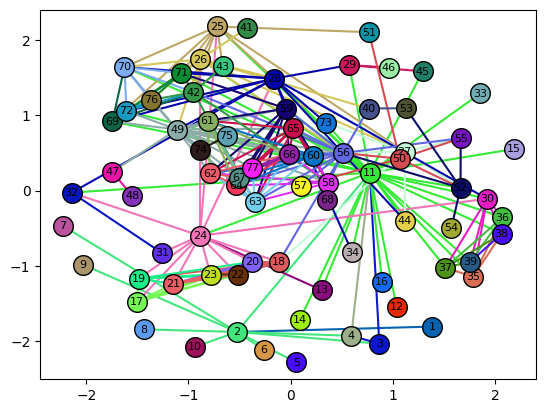

In [96]:
'''Step 3: Les Forced Directed Layout'''
# file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/LesMiserables.dot"
# nodes, edges, adj_matrix = parse_dot_file(file_path)
# main(nodes, edges, "force", node_size=200, directed=True, k=0.08, iterations=10000)

In [16]:
# '''Step 4: Layered layout'''
# file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/noname.dot"
# nodes, edges, adj_matrix = parse_dot_file(file_path)
# main(nodes, edges, 'tree', directed=True)

(77, 77)
[[0.         0.44737153 0.51546443 ... 0.22008185 0.72018746 0.19764263]
 [0.44737153 0.         0.36228273 ... 0.28626003 0.53741981 0.23189807]
 [0.51546443 0.36228273 0.         ... 0.22098527 0.48908888 0.21234826]
 ...
 [0.22008185 0.28626003 0.22098527 ... 0.         0.23999423 0.42013554]
 [0.72018746 0.53741981 0.48908888 ... 0.23999423 0.         0.21104351]
 [0.19764263 0.23189807 0.21234826 ... 0.42013554 0.21104351 0.        ]]
<class 'numpy.ndarray'>


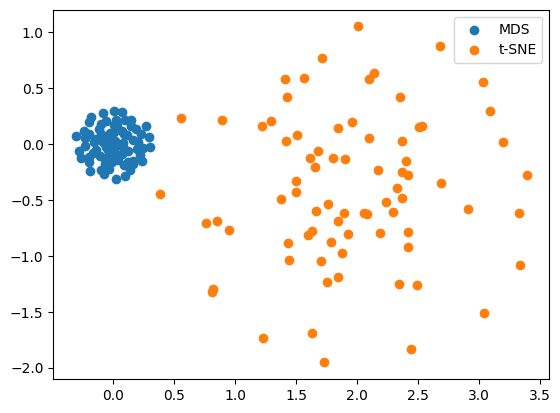

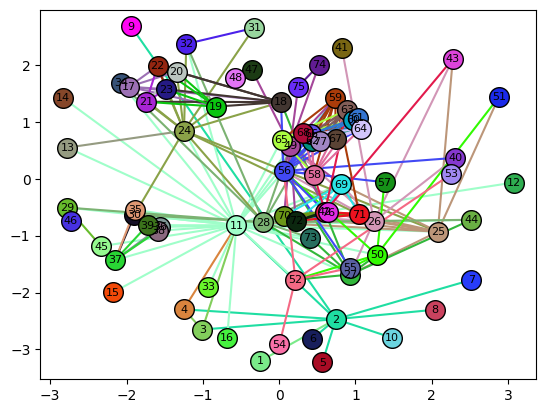

(['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '44',
  '45',
  '49',
  '50',
  '52',
  '56',
  '59',
  '65',
  '69',
  '70',
  '71',
  '72',
  '73',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '31',
  '42',
  '43',
  '51',
  '40',
  '41',
  '76',
  '55',
  '46',
  '53',
  '58',
  '63',
  '47',
  '48',
  '60',
  '61',
  '62',
  '64',
  '66',
  '67',
  '74',
  '75',
  '77',
  '57',
  '54',
  '68'],
 [('1', '2', {'weight': '1'}),
  ('2', '3', {'weight': '8'}),
  ('2', '4', {'weight': '10'}),
  ('2', '5', {'weight': '1'}),
  ('2', '6', {'weight': '1'}),
  ('2', '7', {'weight': '1'}),
  ('2', '8', {'weight': '1'}),
  ('2', '9', {'weight': '2'}),
  ('2', '10', {'weight': '1'}),
  ('2', '11', {'weight': '5'}),
  ('3', '4', {'weight': '6'}),
  ('3', '11', {'weight': '3'}),
  ('4', '11', {'

In [144]:
'''Step 6: Projections for graphs'''
file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/LesMiserables.dot"
nodes, edges, adj_matrix = parse_dot_file(file_path)
main(nodes, edges, "force", node_size=200, directed=True, k=0.15, iterations=1000, projection=True)